In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:


def lorenzatt(X, rho=28.0, sigma=10.0, beta=3.0/8.0):
    '''
    Lorenz Attractor equations (to be solved with scipy.integrate.odeint)
    
    x' = sigma*(y-x)
    y' = x*(rho - z) - y
    z' = x*y - beta*z
    '''
    
    dx = np.zeros((3), 'd')
    dx[0] = sigma*(X[1] - X[0]);
    dx[1] = X[0]*(rho - X[2]) - X[1]
    dx[2] = X[0]*X[1] - beta*X[2]
    return dx


class L40(object):
    '''Lorenz 40 model of zonal atmospheric flow'''
    
    def __init__(self, members=1, n=40, dt=0.05, F=8):  
        self.n = n
        self.dt = dt
        self.dtx = dt
        self.x = np.random.normal(0., 0.1, size=(members, n))
        self.members = members
        self.F = F
    
    def dxdt(self):
        dxdt = np.zeros((self.members, self.n),'f8')
        for n in range(2,self.n-1):
            dxdt[:,n] = -self.x[:,n-2]*self.x[:,n-1] +  \
                        self.x[:,n-1]*self.x[:,n+1] - self.x[:,n] + self.F
        dxdt[:,0] = -self.x[:,self.n-2]*self.x[:,self.n-1] +  \
                self.x[:,self.n-1]*self.x[:,1] - self.x[:,0] + self.F
        dxdt[:,1] = -self.x[:,self.n-1]*self.x[:,0] + \
                self.x[:,0]*self.x[:,2] - self.x[:,1] + self.F
        dxdt[:,self.n-1] = -self.x[:,self.n-3]*self.x[:,self.n-2] + \
                            self.x[:,self.n-2]*self.x[:,0] - \
                            self.x[:,self.n-1] + self.F
        return dxdt
    
    def rk4step(self):
        h = self.dt; hh = 0.5*h; h6 = h/6.
        x = self.x
        dxdt1 = self.dxdt()
        self.x = x + hh*dxdt1
        dxdt2 = self.dxdt()
        self.x = x + hh*dxdt2
        dxdt = self.dxdt()
        self.x = x + h*dxdt
        dxdt2 = 2.0*(dxdt2 + dxdt)
        dxdt = self.dxdt()
        self.x = x + h6*(dxdt1 + dxdt + dxdt2)
    
    #---function to calculate xb_bar, xb_prime, Pb, and K
    def get_xb(self,H,R):
        xb_bar = self.x.mean(axis=0)
        xb_prime = self.x-xb_bar 
        Pb = np.sum(xb_prime[:,np.newaxis,:]*xb_prime[:,:,np.newaxis],axis=0)/(self.members-1)
        K = np.dot(np.dot(Pb,H.T),np.linalg.inv(np.dot(np.dot(H,Pb),H.T)+R))
        return xb_bar, xb_prime, Pb, K
    
    #---The square root filter function
    def assim(self,obs_std,mx,H):
        self.obs_std = obs_std
        self.mx = mx #----mx is the truth
        self.H = H
        dim = self.x.shape[1]
        I = np.eye(dim,dim)
        obs = np.dot(self.H,mx)
        N_obs = len(obs)
        R = self.obs_std**2*np.eye(N_obs)
        xb_bar, xb_prime, Pb, K = self.get_xb(self.H,R) 
        xa_bar = xb_bar+np.dot(K,(obs-np.dot(self.H,xb_bar)))
        Kt = K.copy()
        for i in range(N_obs):
            alpha = (1.+np.sqrt(R[i,i]/(np.dot(np.dot(self.H[i,:],Pb),self.H[i,:].T)+R[i,i])))**(-1)
            Kt[:,i] = K[:,i]*alpha    
            dim = xb_prime.shape
            xa_prime = np.zeros((self.members,dim[1]))
            xa = np.zeros_like(xa_prime)
            for j in range(self.members):
                xa_prime[j,:] = xb_prime[j,:]+np.dot(Kt[:,i],(-np.dot(self.H[i,:],xb_prime[j,:])))
                xa[j,:] = xa_bar+xa_prime[j,:]
            #---update ensemble
            self.x = xa
            xb_bar, xb_prime, Pb, K = self.get_xb(self.H,R)
        return xa 
    
    #---enkf
    def assim2(self,obs_std,mx,H):
        self.obs_std = obs_std
        self.mx = mx
        self.H = H
        obs = np.dot(self.H,mx)
        N_obs = len(obs)
        R = self.obs_std**2*np.eye(N_obs)
        xb_bar, xb_prime, Pb, K = self.get_xb(self.H,R)
        dim = np.shape(Pb)
        I = np.eye(dim[0],dim[1])
        xa_bar = xb_bar+np.dot(K,(obs-np.dot(self.H,xb_bar)))
        dim = xb_prime.shape
        obs_prime = obs_std*np.random.randn(self.members,N_obs)
        xa_prime = np.zeros((self.members,dim[1]))
        xa = np.zeros_like(xa_prime)
        for i in range(self.members):
            xa_prime[i,:] = xb_prime[i,:]+np.dot(K,(obs_prime[i,:]-np.dot(self.H,xb_prime[i,:])))
            xa[i,:] = xa_bar+xa_prime[i,:] 
        return xa

In [5]:
sim_lenth = 1000 
N_o1 = 40  
N_o2 = 20
members = 50 
obs_std = 1. 

#----fancy H when N_o = 40
a = np.arange(0,40)
H = np.ones(40)[np.newaxis,:]
for i in range(1, N_o1):
    H = np.append(H,np.cos(i*a/39.*np.pi)[np.newaxis,:],axis=0)

#---fancy H when N_o = 20
a = np.arange(0,40)
H1 = np.ones(40)[np.newaxis,:]
for i in range(1, N_o2):
    H1 = np.append(H1,np.cos(i*a/39.*np.pi)[np.newaxis,:],axis=0)    

#---plain H when N_o = 40
H2 = np.eye(N_o1,40)
#---plain H when N_o = 20
H3 = np.eye(40,40)[::2]

In [6]:
#---function to get the assimilation operated
def id_assim(L1,L2,mx0,ensx0,sim_lenth,cyclen,obs_std,H,member,asim):
    L1.x[0] = mx0 #---always start with the same initial truth
    L2.x = ensx0 #---always start with the same initial ensemble
    error = []
    for i in range(0,sim_lenth):
        L1.rk4step()
        L2.rk4step()       
        if np.mod(i, cyclen)==0:
            if asim==1: #---If assim == 1, use the square root filter
                L2.x = L2.assim(obs_std,L1.x[0],H)
            else: #---else, use the perturbed one
                L2.x = L2.assim2(obs_std,L1.x[0],H)
        error = np.append(error, np.mean(np.sqrt((L1.x[0]-np.mean(L2.x,axis=0))**2)))
        if i == 0:
            hist_error = np.sqrt((L1.x[0]-np.mean(L1.x,axis=0))**2)[np.newaxis,:]
        else:
            hist_error = np.append(hist_error,np.sqrt((L1.x[0]-np.mean(L2.x,axis=0))**2)[np.newaxis,:],axis=0)    
    return error, hist_error

In [7]:
#---Set the initial truth and ensemble. All cases are using the same initials.
m = L40()
ens = L40(members=50)
mx0 = m.x[0]
ensx0 = ens.x

In [8]:
#---sqrt fancy H, N_obs = 40
error_s1, hist_error_s1 = id_assim(m,ens,mx0,ensx0,sim_lenth,1,obs_std,H,members,1)
error_s3, hist_error_s3 = id_assim(m,ens,mx0,ensx0,sim_lenth,3,obs_std,H,members,1)
error_s10, hist_error_s10 = id_assim(m,ens,mx0,ensx0,sim_lenth,10,obs_std,H,members,1)

In [9]:
#---sqrt plain H, N_obs = 40
error_s12, hist_error_s12 = id_assim(m,ens,mx0,ensx0,sim_lenth,1,obs_std,H2,members,1)
error_s32, hist_error_s32 = id_assim(m,ens,mx0,ensx0,sim_lenth,3,obs_std,H2,members,1)
error_s102, hist_error_S102 = id_assim(m,ens,mx0,ensx0,sim_lenth,10,obs_std,H2,members,1)

In [10]:
#---enkf fancy H, N_obs = 40
error_e1, hist_error_e1 = id_assim(m,ens,mx0,ensx0,sim_lenth,1,obs_std,H,members,0)
error_e3, hist_error_e3 = id_assim(m,ens,mx0,ensx0,sim_lenth,3,obs_std,H,members,0)
error_e10, hist_error_e10 = id_assim(m,ens,mx0,ensx0,sim_lenth,10,obs_std,H,members,0)

In [11]:
#---enkf plain H, N_obs = 40
error_e12, hist_error_e12 = id_assim(m,ens,mx0,ensx0,sim_lenth,1,obs_std,H2,members,0)
error_e32, hist_error_e32 = id_assim(m,ens,mx0,ensx0,sim_lenth,3,obs_std,H2,members,0)
error_e102, hist_error_e102 = id_assim(m,ens,mx0,ensx0,sim_lenth,10,obs_std,H2,members,0)

In [12]:
#---sqrt fancy H, N_obs = 20
error_s21, hist_error_s21 = id_assim(m,ens,mx0,ensx0,sim_lenth,1,obs_std,H1,members,1)
error_s23, hist_error_s23 = id_assim(m,ens,mx0,ensx0,sim_lenth,3,obs_std,H1,members,1)
error_s210, hist_error_s210 = id_assim(m,ens,mx0,ensx0,sim_lenth,10,obs_std,H1,members,1)

In [13]:
#---sqrt plain H, N_obs = 20
error_s212, hist_error_s212 = id_assim(m,ens,mx0,ensx0,sim_lenth,1,obs_std,H3,members,1)
error_s232, hist_error_s232 = id_assim(m,ens,mx0,ensx0,sim_lenth,3,obs_std,H3,members,1)
error_s2102, hist_error_s2102 = id_assim(m,ens,mx0,ensx0,sim_lenth,10,obs_std,H3,members,1)

In [14]:
#---enkf fancy H, N_obs = 20
error_e21, hist_error_e21 = id_assim(m,ens,mx0,ensx0,sim_lenth,1,obs_std,H1,members,0)
error_e23, hist_error_e23 = id_assim(m,ens,mx0,ensx0,sim_lenth,3,obs_std,H1,members,0)
error_e210, hist_error_e210 = id_assim(m,ens,mx0,ensx0,sim_lenth,10,obs_std,H1,members,0)

In [15]:
#---enkf plain H, N_obs = 20
error_e212, hist_error_e212 = id_assim(m,ens,mx0,ensx0,sim_lenth,1,obs_std,H3,members,0)
error_e232, hist_error_e232 = id_assim(m,ens,mx0,ensx0,sim_lenth,3,obs_std,H3,members,0)
error_e2102, hist_error_e2102 = id_assim(m,ens,mx0,ensx0,sim_lenth,10,obs_std,H3,members,0)

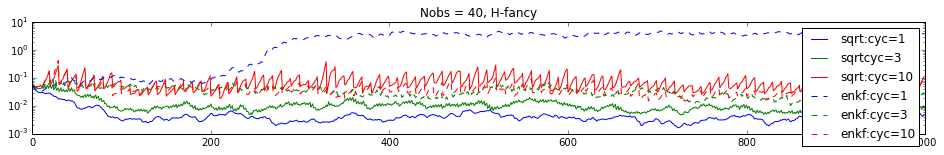

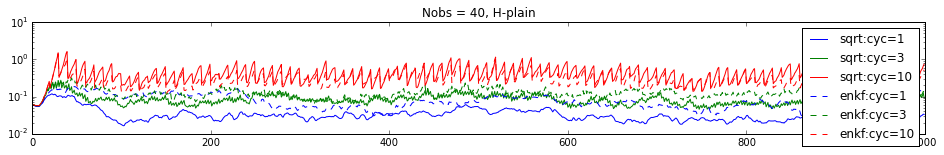

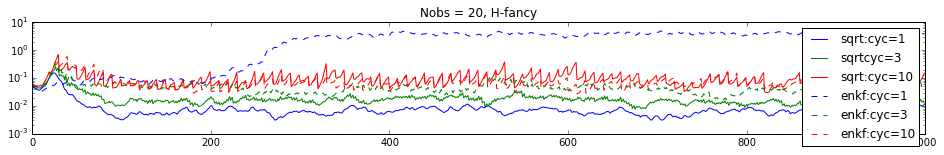

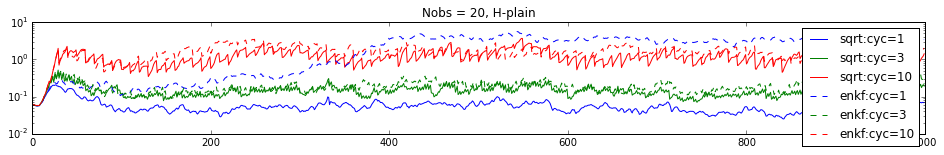

In [21]:
fig = plt.figure()
fig.set_size_inches(16,2,forward=True)
plt.plot(error_s1,'b',label = 'sqrt:cyc=1')
plt.plot(error_s3,'g',label = 'sqrtcyc=3')
plt.plot(error_s10,'r',label = 'sqrt:cyc=10')
plt.plot(error_e1,'b--',label = 'enkf:cyc=1')
plt.plot(error_e3,'g--',label = 'enkf:cyc=3')
plt.plot(error_e10,'r--',label = 'enkf:cyc=10')
plt.legend()
plt.yscale('log')
plt.title('Nobs = 40, H-fancy')

fig = plt.figure()
fig.set_size_inches(16,2,forward=True)
plt.plot(error_s12,'b',label = 'sqrt:cyc=1')
plt.plot(error_s32,'g',label = 'sqrt:cyc=3')
plt.plot(error_s102,'r',label = 'sqrt:cyc=10')
plt.plot(error_e12,'b--',label = 'enkf:cyc=1')
plt.plot(error_e32,'g--',label = 'enkf:cyc=3')
plt.plot(error_e102,'r--',label = 'enkf:cyc=10')
plt.title('Nobs = 40, H-plain')
plt.yscale('log')
plt.legend()

fig = plt.figure()
fig.set_size_inches(16,2,forward=True)
plt.plot(error_s21,'b',label = 'sqrt:cyc=1')
plt.plot(error_s23,'g',label = 'sqrtcyc=3')
plt.plot(error_s210,'r',label = 'sqrt:cyc=10')
plt.plot(error_e1,'b--',label = 'enkf:cyc=1')
plt.plot(error_e23,'g--',label = 'enkf:cyc=3')
plt.plot(error_e210,'r--',label = 'enkf:cyc=10')
plt.legend()
plt.yscale('log')
plt.title('Nobs = 20, H-fancy')

fig = plt.figure()
fig.set_size_inches(16,2,forward=True)
plt.plot(error_s212,'b',label = 'sqrt:cyc=1')
plt.plot(error_s232,'g',label = 'sqrt:cyc=3')
plt.plot(error_s2102,'r',label = 'sqrt:cyc=10')
plt.plot(error_e212,'b--',label = 'enkf:cyc=1')
plt.plot(error_e232,'g--',label = 'enkf:cyc=3')
plt.plot(error_e2102,'r--',label = 'enkf:cyc=10')
plt.title('Nobs = 20, H-plain')
plt.legend()
plt.yscale('log')

In [26]:
#---A TEST---
m=L40()
ens=L40(members=50)
error = []
for i in range(0,1000):
    ens.rk4step()
    m.rk4step()
    if np.mod(i, 1)==0:
        ens.x = ens.assim(obs_std,m.x[0],H)
    error = np.append(error, np.mean(np.sqrt((m.x[0]-np.mean(ens.x,axis=0))**2)))
    if i == 0:
        hist_error = np.sqrt((m.x[0]-np.mean(ens.x,axis=0))**2)[np.newaxis,:]
    else:
        hist_error = np.append(hist_error,np.sqrt((m.x[0]-np.mean(ens.x,axis=0))**2)[np.newaxis,:],axis=0)


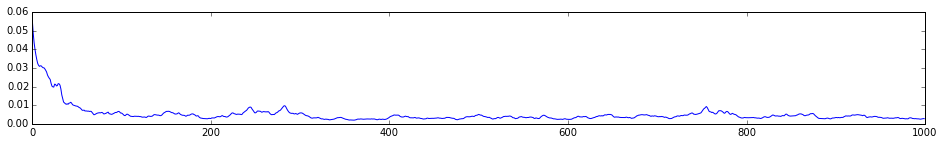

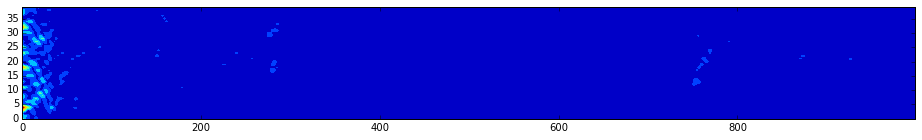

In [27]:
fig = plt.figure()
fig.set_size_inches(16,2,forward=True)
plt.plot(error)

fig = plt.figure()
plt.contourf(hist_error.T)
fig.set_size_inches(16,2,forward=True)